### 7.1.1 Downloading CIFAR-10

In [18]:
from torchvision import datasets
from PIL import Image
from matplotlib import pyplot as plt
import torch

In [2]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

51.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


- We can see that the method-resolution order of our `cifar10` instance includes `torch.utils.data.Dataset` as a base class.

In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

### 7.1.2 The Dataset class

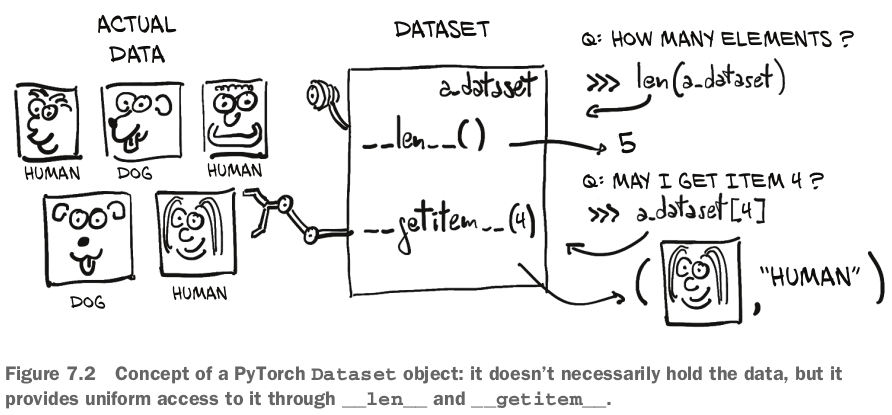

In [5]:
Image.open('img/dataset-object-2020-12-26-21-55-27.png')

- `Dataset` is an object that is **required to implement two methods**: `__len__` and `__getitem__`.
- なるほど！In practice, **when a Python object is equipped with the `__len__` method, we can pass it as an argument to the `len` Python built-in function**:

In [6]:
len(cifar10)

50000

- なるほど！Similarly, since the dataset is **equipped with the `__getitem__` method**, we can use the **standard subscript for indexing tuples and lists** to access individual items:

In [7]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FEF1142A160>,
 1,
 'automobile')

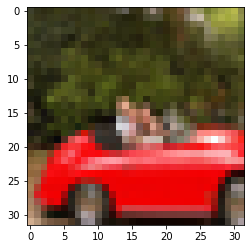

In [9]:
plt.imshow(img)
plt.show()

### 7.1.3 Dataset transforms

In [10]:
from torchvision import transforms

In [11]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [12]:
# PILToTensorも存在しているけど
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.share_memory_pe

torch.Size([3, 32, 32])

- We **can pass the transform directly as an argument to `dataset.CIFAR10`**:

In [13]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                 transform=transforms.ToTensor())

- At this point, accessing an element of the dataset will return a tensor, rather than a PIL image:

In [14]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [15]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

- `ToTensor` transform turns the data into a 32-bit floating-point per channel, scaling the values down from 0.0 to 1.0:

In [16]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

- We're getting the same image out:

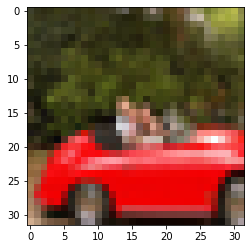

In [17]:
# changes the order of the axes from CxHxW to HxWxC to match what Matplotlib expects.
plt.imshow(img_t.permute(1, 2, 0)) 
plt.show()

### 7.1.4 Normalizing data
- Transforms are really handy because we can chain them using `transforms.Compose`, and they can handle normalization and data augmentation transparently, directly in the data loader.
- Let's **stack** all the tensors returned by the dataset along an extra dimension:

In [19]:
# Since the CIFAR-10 dataset is small, we'll be able to manipulate it entirely in memory.
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

- Compute the mean per channel:

In [23]:
imgs_mean = imgs.view(3, -1).mean(dim=1)
imgs_mean

tensor([0.4914, 0.4822, 0.4465])

In [21]:
imgs.view(3, -1).shape

torch.Size([3, 51200000])

- Compute the standard deviation per channel:

In [24]:
imgs_std = imgs.view(3, -1).std(dim=1)
imgs_std

tensor([0.2470, 0.2435, 0.2616])

- With these numbers in our hands, we can initialize the `Normalize` transform:

In [25]:
transforms.Normalize(mean=imgs_mean, std=imgs_std)

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

- Concatenate it after the `ToTensor` transform:

In [28]:
# 本には直接に数字のlistを使っているが、ここでtensor形のmean, stdを使っても大丈夫らしい。
transformed_cifar10 = datasets.CIFAR10(data_path,
                                      train=True,
                                      download=False,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(imgs_mean, imgs_std)
                                      ]))

- **At this point, plotting an image drawn from the dataset won't provide us with a faithful representation of the actual image**: なぜなら今mean=0, std=1だよ、つまりマイナスの値も入っている。下記のwarningのように、期待されているRGB valueは(0,1)か(0,255)だ。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


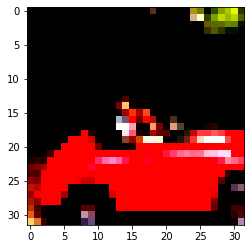

In [27]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()